In [1]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:49<00:00, 136MB/s]
100% 3.75G/3.75G [00:49<00:00, 81.1MB/s]


In [2]:

import zipfile
zip_ref = zipfile.ZipFile('/content/140k-real-and-fake-faces.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

#### Data loading

In [4]:
#main path is provided in which images are being downloaded
main_path = '/content/real_vs_fake/real-vs-fake'
#joining the path to the train,valid,test directories using the join() function available in os.path module
train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [5]:
#listdir() will give the subfolders that are present in the particular directory
print("Train_dir splitted_data: ", os.listdir(train_dir))
print("Valid_dir splitted_data: ", os.listdir(valid_dir))
print("Test_dir splitted_data: ", os.listdir(test_dir))

Train_dir splitted_data:  ['real', 'fake']
Valid_dir splitted_data:  ['real', 'fake']
Test_dir splitted_data:  ['real', 'fake']


In [6]:
#creating the dictionaries for real_images and fake_images
real_images_df = {
    "splitted_data":[],
    "image_path":[],
    "label":[]
}
fake_images_df = {
    "splitted_data":[],
    "image_path":[],
    "label":[]
}
for splitted_data in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + splitted_data): #iterate on fake and real labels
        if(label=='real'):
        #glob.glob() is a function which is used to search for a particular extension files that means it returns a list containing all the files related to given extension
        #iterate on images in folders
            for img in glob.glob(main_path + "/" + splitted_data + "/" + label + "/*.jpg"):
                real_images_df["splitted_data"].append(splitted_data)
                real_images_df["image_path"].append(img)
                real_images_df["label"].append(label)
        else:
            for img in glob.glob(main_path + "/" + splitted_data + "/" + label + "/*.jpg"):
                fake_images_df["splitted_data"].append(splitted_data)
                fake_images_df["image_path"].append(img)
                fake_images_df["label"].append(label)


In [7]:
#converting the dictionaries into a dataframes
real_images_df =pd.DataFrame(real_images_df)
fake_images_df = pd.DataFrame(fake_images_df)
real_images_df

,splitted_data,image_path,label
0,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
1,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
2,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
3,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
4,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
...,...,...,...
69995,test,/content/real_vs_fake/real-vs-fake/test/real/6...,real
69996,test,/content/real_vs_fake/real-vs-fake/test/real/3...,real
69997,test,/content/real_vs_fake/real-vs-fake/test/real/2...,real
69998,test,/content/real_vs_fake/real-vs-fake/test/real/3...,real


In [8]:
fake_images_df

,splitted_data,image_path,label
0,valid,/content/real_vs_fake/real-vs-fake/valid/fake/...,fake
1,valid,/content/real_vs_fake/real-vs-fake/valid/fake/...,fake
2,valid,/content/real_vs_fake/real-vs-fake/valid/fake/...,fake
3,valid,/content/real_vs_fake/real-vs-fake/valid/fake/...,fake
4,valid,/content/real_vs_fake/real-vs-fake/valid/fake/...,fake
...,...,...,...
69995,test,/content/real_vs_fake/real-vs-fake/test/fake/R...,fake
69996,test,/content/real_vs_fake/real-vs-fake/test/fake/M...,fake
69997,test,/content/real_vs_fake/real-vs-fake/test/fake/Y...,fake
69998,test,/content/real_vs_fake/real-vs-fake/test/fake/R...,fake


In [9]:
#concatenating the dataframes real_images and fake_images
images_df = pd.concat([real_images_df, fake_images_df])
images_df

,splitted_data,image_path,label
0,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
1,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
2,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
3,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
4,valid,/content/real_vs_fake/real-vs-fake/valid/real/...,real
...,...,...,...
69995,test,/content/real_vs_fake/real-vs-fake/test/fake/R...,fake
69996,test,/content/real_vs_fake/real-vs-fake/test/fake/M...,fake
69997,test,/content/real_vs_fake/real-vs-fake/test/fake/Y...,fake
69998,test,/content/real_vs_fake/real-vs-fake/test/fake/R...,fake


In [10]:
#understanding what is present in the column splitted_data of real_images_df
real_df=real_images_df['splitted_data']
real_df

0        valid
1        valid
2        valid
3        valid
4        valid
         ...  
69995     test
69996     test
69997     test
69998     test
69999     test
Name: splitted_data, Length: 70000, dtype: object

In [11]:
#finding the count of the each type of data in splitted_data
real_test_count=real_train_count=real_valid_count=0
for data in real_df:
    if(data=='test'):
        real_test_count+=1
    if(data=='train'):
        real_train_count+=1
    if(data=='valid'):
        real_valid_count+=1
print("real_test_count:",real_test_count)
print("real_train_count:",real_train_count)
print("real_valid_count:",real_valid_count)

real_test_count: 10000
real_train_count: 50000
real_valid_count: 10000


In [12]:
#understanding what is present in the column splitted_data of fake_images_df
fake_df=fake_images_df['splitted_data']
fake_df

0        valid
1        valid
2        valid
3        valid
4        valid
         ...  
69995     test
69996     test
69997     test
69998     test
69999     test
Name: splitted_data, Length: 70000, dtype: object

In [13]:
#finding the count of the each type of data in splitted_data of fake_images_df-
fake_test_count=0
fake_train_count=0
fake_valid_count=0
for data in fake_df:
    if(data=='test'):
        fake_test_count+=1
    if(data=='train'):
        fake_train_count+=1
    if(data=='valid'):
        fake_valid_count+=1
print("fake_test_count:",fake_test_count)
print("fake_train_count:",fake_train_count)
print("fake_valid_count:",fake_valid_count)

fake_test_count: 10000
fake_train_count: 50000
fake_valid_count: 10000


In [14]:
import tensorflow as tf
from tensorflow import keras

##### Data Preprocessing which involves data resizing,normalization and augmentation

In [15]:
#normalization which is done to convert the large pixels format(0-225) to 0-1 which will be helpful for mathematical applications
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [16]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [17]:
#this function will plot the images it takes image and label as parameters
#figsize=[12,12] it will create like a container of 12x12 inches and loop starts iterating it will plot 16 images
#in this area a subplot is plotted with as 4x4 and i+1 refers to the value between 1-16 then the image is displayed using imshow function
#axis('off') says the axis for every current plot willn't be visualized
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

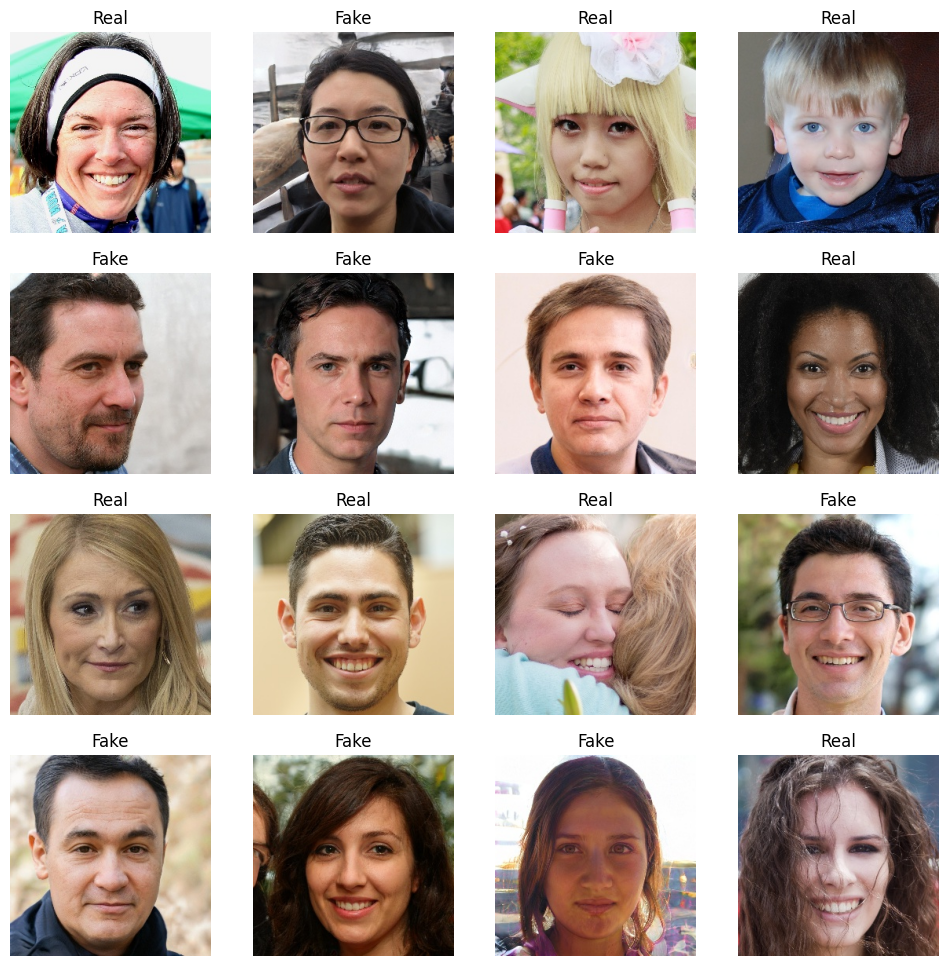

In [18]:
img,lbl = next(train_ds)
plot_images(img,lbl)

In [19]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.07450981 0.08235294 0.07843138]
  [0.07450981 0.08235294 0.07843138]
  [0.07450981 0.08235294 0.07843138]
  ...
  [0.72156864 0.73333335 0.6509804 ]
  [0.73333335 0.7372549  0.6745098 ]
  [0.74509805 0.7372549  0.6862745 ]]

 [[0.07450981 0.08235294 0.07843138]
  [0.07843138 0.08627451 0.08235294]
  [0.07843138 0.08627451 0.08235294]
  ...
  [0.6901961  0.7254902  0.6431373 ]
  [0.69803923 0.7254902  0.6627451 ]
  [0.7058824  0.72156864 0.6666667 ]]

 [[0.07450981 0.08235294 0.07843138]
  [0.07450981 0.08235294 0.07843138]
  [0.07450981 0.08235294 0.07843138]
  ...
  [0.427451   0.50980395 0.43529415]
  [0.45882356 0.5294118  0.4666667 ]
  [0.47450984 0.54509807 0.4901961 ]]

 ...

 [[0.17254902 0.13333334 0.227451  ]
  [0.17254902 0.1254902  0.21960786]
  [0.15294118 0.11764707 0.20000002]
  ...
  [0.08627451 0.0509804  0.05490196]
  [0.09803922 0.05882353 0.0627451 ]
  [0.10588236 0.06666667 0.07058824]]

 [[0.14901961 0.12156864 0.18431373]
  [0.14117648 0.10588236 0.1

In [20]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [21]:
input_shape = (256,256,3)

In [22]:
#create the model's architecture and compile it
def get_model(input_shape):
    #an input layer of the architecture is created with the input_tensor of defined input_shape
    input = tf.keras.Input(shape=input_shape)
    #densenet121 is instantiated with weights as imagenet,include_top is the top classification layer which sets as False and input_tensor is our created input layer.
    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)
    #global average Pooling layer has added to the output of the densenet121 to reduce the feature map to the single value
    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

    return model


In [23]:
model_ft = get_model(input_shape)

model_ft.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [24]:
checkpoint_filepath = "fake_vs_real_cp.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True)

In [25]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=5,
                                                     restore_best_weights=True,
                                                    )


In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [27]:
history_ft = model_ft.fit(train_ds,
                       epochs = 5,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/5
1563/1563 [==============================] - 1490s 894ms/step - loss: 0.1375 - accuracy: 0.9443 - precision: 0.9430 - recall: 0.9458 - val_loss: 0.3185 - val_accuracy: 0.8611 - val_precision: 0.8107 - val_recall: 0.9423 - lr: 0.0010
Epoch 2/5
1563/1563 [==============================] - 1376s 880ms/step - loss: 0.0511 - accuracy: 0.9812 - precision: 0.9803 - recall: 0.9820 - val_loss: 0.4611 - val_accuracy: 0.8375 - val_precision: 0.7583 - val_recall: 0.9907 - lr: 0.0010
Epoch 3/5
1563/1563 [==============================] - 1364s 873ms/step - loss: 0.0405 - accuracy: 0.9851 - precision: 0.9845 - recall: 0.9858 - val_loss: 0.1832 - val_accuracy: 0.9277 - val_precision: 0.8781 - val_recall: 0.9933 - lr: 0.0010
Epoch 4/5
1563/1563 [==============================] - 1373s 879ms/step - loss: 0.0348 - accuracy: 0.9873 - precision: 0.9867 - recall: 0.9880 - val_loss: 0.1308 - val_accuracy: 0.9495 - val_precision: 0.9362 - val_recall: 0.9646 - lr: 0.0010
Epoch 5/5
1563/1563 [=======

In [28]:
model_ft.save('deepfake.keras')

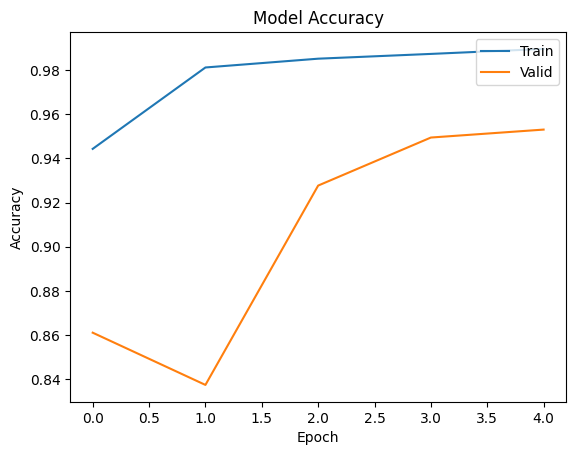

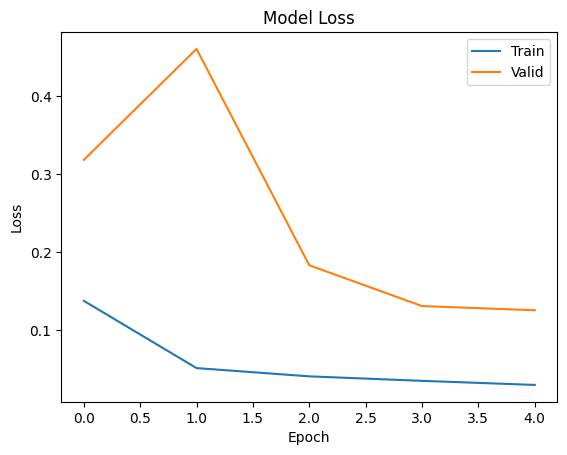

In [46]:
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [30]:
# Evaluate the model on the test set
test_loss, test_acc,precision,recall = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Precision:", precision)
print("Recall:", recall)
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1-Score :",f1_score)

313/313 [==============================] - 81s 258ms/step - loss: 0.1283 - accuracy: 0.9517 - precision: 0.9958 - recall: 0.9071
Test Loss: 0.1283368170261383
Test Accuracy: 0.9516500234603882
Precision: 0.9958283305168152
Recall: 0.9071000218391418
F1-Score : 0.9493955978336983


In [47]:
model = get_model(input_shape)
# Restore the weights
model.load_weights('/content/fake_vs_real_cp.h5')

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Evaluate the model on the test set
test_loss, test_acc,precision,recall = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Precision:", precision)
print("Recall:", recall)
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1-Score :",f1_score)

313/313 [==============================] - 82s 246ms/step - loss: 0.1283 - accuracy: 0.9517 - precision: 0.9958 - recall: 0.9071
Test Loss: 0.1283368170261383
Test Accuracy: 0.9516500234603882
Precision: 0.9958283305168152
Recall: 0.9071000218391418
F1-Score : 0.9493955978336983


In [40]:

predicted_labels = model.predict(test_ds)
true_labels = test_ds.classes
cm=metrics.confusion_matrix(true_labels, predicted_labels.round())
print(cm)

313/313 [==============================] - 77s 246ms/step
[[9962   38]
 [ 929 9071]]


1/1 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'This image is 99.67% Fake and 0.33% Real.')

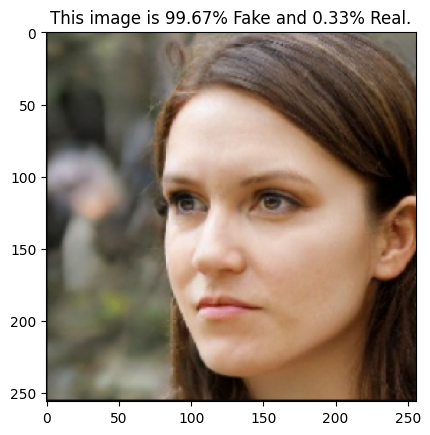

In [45]:
test_image = tf.keras.preprocessing.image.load_img('/content/Screenshot 2024-06-05 133808.png', target_size=(256, 256, 3))
plt.imshow(test_image)


test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")